# Chapter 3. Classification

### Ensure GPU environment is setup

In [1]:
import tensorflow as tf
from tensorflow import keras 

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
tf.test.is_built_with_cuda()

True

In [4]:
print(tf.version.VERSION)

2.1.0


In [5]:
import sys
sys.version

'3.6.13 |Anaconda, Inc.| (default, Mar 16 2021, 11:37:27) [MSC v.1916 64 bit (AMD64)]'

## MNIST dataset

In [6]:
from sklearn.datasets import fetch_openml 
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [7]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


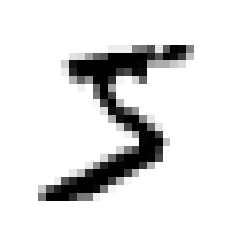

In [8]:
#Reshape matrix to view image as 28x28
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
plt.show()

In [9]:
y[0]

'5'

In [10]:
#Change string to int for numerical input in model
import numpy as np
y = y.astype(np.uint8)

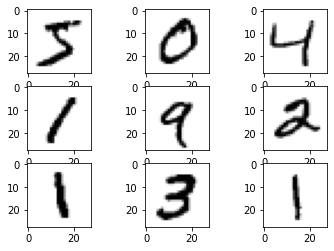

In [11]:
for i in range(9):
    plt.subplot(3,3,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(X[i].reshape(28, 28), cmap="binary")

plt.show()

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Training a Binary Classifer

In [13]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)


In [14]:
#Stochastic Gradient Descent Classifier 
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [15]:
sgd_clf.predict([some_digit])

array([ True])

[False]


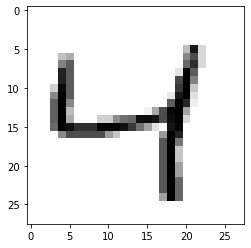

In [16]:
print(sgd_clf.predict([X[2]])) # Check for another variable
plt.imshow(X[2].reshape(28, 28), cmap="binary")


###  Measure Accuracy Using Stratified KFold Cross Validation 

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
 clone_clf = clone(sgd_clf)
 X_train_folds = X_train[train_index]
 y_train_folds = y_train_5[train_index]
 X_test_fold = X_train[test_index]
 y_test_fold = y_train_5[test_index]
 clone_clf.fit(X_train_folds, y_train_folds)
 y_pred = clone_clf.predict(X_test_fold)
 n_correct = sum(y_pred == y_test_fold)
 print(n_correct / len(y_pred)) # prints 0.9502, 0.96565, and 0.96495

0.9669
0.91625
0.96785


In [18]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.95035, 0.96035, 0.9604 ])

In [19]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
 def fit(self, X, y=None):
  return self
 def predict(self, X):
  return np.zeros((len(X), 1), dtype=bool)


In [20]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy") # K = 3

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix

In [21]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Each row in the confusion matrix represents an actual class. While each column represents a predicted class.

- first row is "not 5" (True Negatives).
- Model incorrectly predicted "5" (False Positives).
- second row is "5" (False Negative)
- Model correctly predicted "5" (True Positives)

In [23]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### Precision and Recall

In [24]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred)) #Precision = TP/(TP+FP)
print(recall_score(y_train_5, y_train_pred)) # Recall = TP/(TP+FN)

0.8370879772350012
0.6511713705958311


### F1 Score

In [25]:
from sklearn.metrics import f1_score # F1= 2((precision*recall)/(precision+recall))
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [26]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[2164.22030239]
[ True]


In [27]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred


array([False])

In [28]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
 method="decision_function")


### Precision/Recall Curve

In [29]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [30]:
print(thresholds)
print(precisions)
print(recalls)

[-106527.45300471 -105763.22240074 -105406.2965229  ...   38871.26391927
   42216.05562787   49441.43765905]
[0.09040123 0.09038606 0.09038757 ... 1.         1.         1.        ]
[1.00000000e+00 9.99815532e-01 9.99815532e-01 ... 3.68935621e-04
 1.84467810e-04 0.00000000e+00]


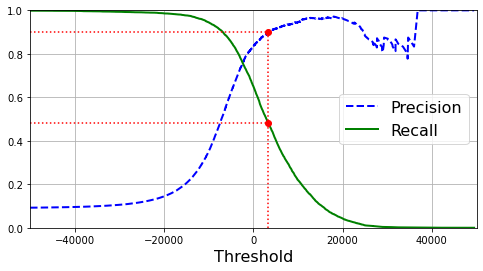

In [31]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown                                             # Not shown
plt.show()

In [32]:
print(recall_90_precision)
print(threshold_90_precision)

0.4799852425751706
3370.0194991439594


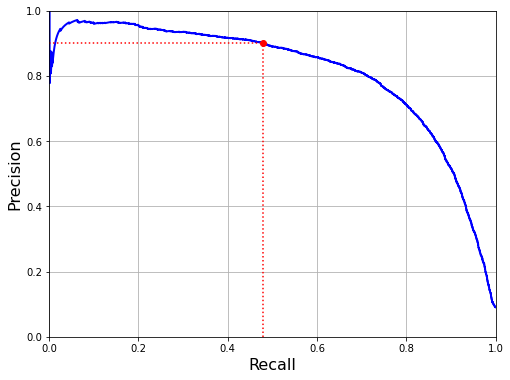

In [33]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [34]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] 
print(threshold_90_precision)

3370.0194991439594


In [35]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [36]:
precision_score(y_train_5, y_train_pred_90)


0.9000345901072293

In [37]:
recall_score(y_train_5, y_train_pred_90)


0.4799852425751706

### ROC Curve

In [38]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

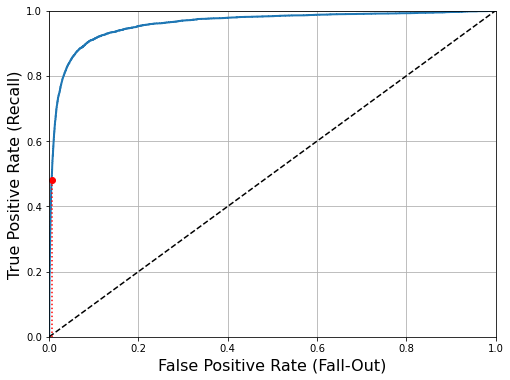

In [39]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
plt.show()

In [40]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [41]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
 method="predict_proba")

In [42]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

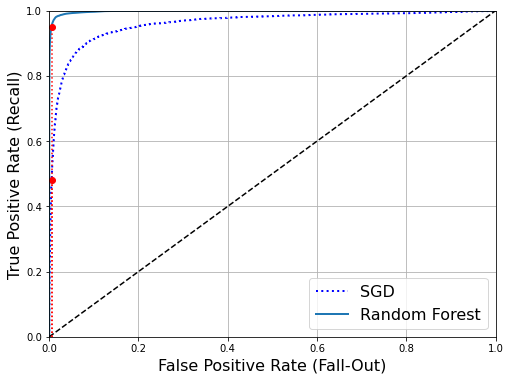

In [43]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [44]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [45]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [46]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

### Multiclass Classification

In [47]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [48]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [49]:
print(np.argmax(some_digit_scores))
print(svm_clf.classes_)
print(svm_clf.classes_[5])

5
[0 1 2 3 4 5 6 7 8 9]
5


In [50]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
print(ovr_clf.predict([some_digit]))
len(ovr_clf.estimators_)

[5]


10

In [51]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [52]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [53]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [54]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

### Error Analysis

In [55]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

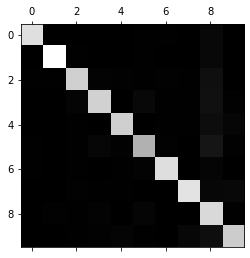

In [56]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [57]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

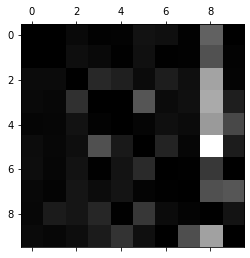

In [58]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [59]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

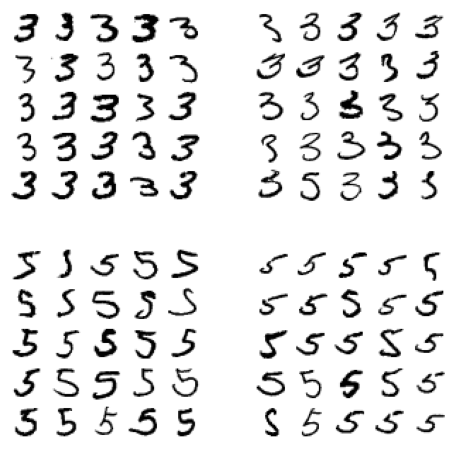

In [60]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()


### Multilabel Classification

In [61]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [62]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [63]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
#f1_score(y_multilabel, y_train_knn_pred, average="macro")
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9778357403921755

### Multi-Output Classification

In [64]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [65]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

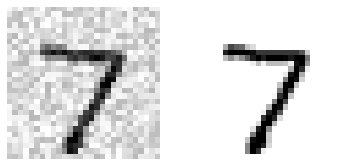

In [66]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

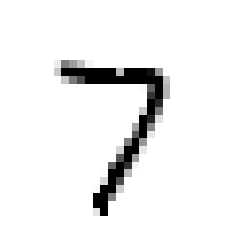

In [67]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

# **Chapter 3 Exercises**

1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy
on the test set. Hint: the KNeighborsClassifier works quite well for this task;
you just need to find good hyperparameter values (try a grid search on the
weights and n_neighbors hyperparameters).
2. Write a function that can shift an MNIST image in any direction (left, right, up,
or down) by one pixel.5 Then, for each image in the training set, create four shif‐
ted copies (one per direction) and add them to the training set. Finally, train your
best model on this expanded training set and measure its accuracy on the test set.
You should observe that your model performs even better now! This technique of
artificially growing the training set is called data augmentation or training set
expansion.
3. Tackle the Titanic dataset. A great place to start is on Kaggle.
4. Build a spam classifier (a more challenging exercise):
• Download examples of spam and ham from Apache SpamAssassin’s public
datasets.
• Unzip the datasets and familiarize yourself with the data format.
• Split the datasets into a training set and a test set.
• Write a data preparation pipeline to convert each email into a feature vector.
Your preparation pipeline should transform an email into a (sparse) vector that
indicates the presence or absence of each possible word. For example, if all
emails only ever contain four words, “Hello,” “how,” “are,” “you,” then the email
“Hello you Hello Hello you” would be converted into a vector [1, 0, 0, 1]
(meaning [“Hello” is present, “how” is absent, “are” is absent, “you” is
present]), or [3, 0, 0, 2] if you prefer to count the number of occurrences of
each word.
You may want to add hyperparameters to your preparation pipeline to control
whether or not to strip off email headers, convert each email to lowercase,
remove punctuation, replace all URLs with “URL,” replace all numbers with
“NUMBER,” or even perform stemming (i.e., trim off word endings; there are
Python libraries available to do this).
Finally, try out several classifiers and see if you can build a great spam classi‐
fier, with both high recall and high precision.


**1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy
on the test set. Hint: the KNeighborsClassifier works quite well for this task;
you just need to find good hyperparameter values (try a grid search on the
weights and n_neighbors hyperparameters).**

In [68]:
from sklearn.model_selection import GridSearchCV

parameters = [{'weights': ['uniform', 'distance'], 'n_neighbors': [3,4]}]
              
knn_obj = KNeighborsClassifier()
grid_search = GridSearchCV(knn_obj, parameters, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ....n_neighbors=3, weights=uniform;, score=0.972 total time=   9.5s
[CV 2/5] END ....n_neighbors=3, weights=uniform;, score=0.971 total time=   9.3s
[CV 3/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=   9.5s
[CV 4/5] END ....n_neighbors=3, weights=uniform;, score=0.969 total time=   9.5s
[CV 5/5] END ....n_neighbors=3, weights=uniform;, score=0.970 total time=   9.2s
[CV 1/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=   9.4s
[CV 2/5] END ...n_neighbors=3, weights=distance;, score=0.972 total time=   9.1s
[CV 3/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=   9.0s
[CV 4/5] END ...n_neighbors=3, weights=distance;, score=0.970 total time=   9.3s
[CV 5/5] END ...n_neighbors=3, weights=distance;, score=0.971 total time=   9.1s
[CV 1/5] END ....n_neighbors=4, weights=uniform;, score=0.969 total time=  12.2s
[CV 2/5] END ....n_neighbors=4, weights=uniform;,

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [69]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [70]:
grid_search.best_score_

0.9716166666666666

In [71]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

**2. Write a function that can shift an MNIST image in any direction (left, right, up,
or down) by one pixel.5 Then, for each image in the training set, create four shif‐
ted copies (one per direction) and add them to the training set. Finally, train your
best model on this expanded training set and measure its accuracy on the test set.
You should observe that your model performs even better now! This technique of
artificially growing the training set is called data augmentation or training set
expansion.**

In [72]:
from scipy.ndimage.interpolation import shift 
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

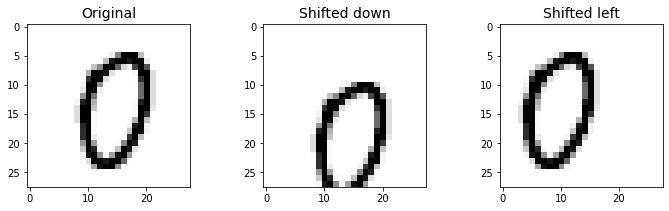

In [73]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [74]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [75]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [76]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [77]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [78]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763

**3. Tackle the Titanic dataset. A great place to start is on Kaggle.**

In [79]:
# Data downloaded locally already from Kaggle: https://www.kaggle.com/c/titanic/data
import pandas as pd 

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [80]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:

- **PassengerId**: a unique identifier for each passenger
- **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
- **Pclass**: passenger class.
- **Name, Sex, Age**: self-explanatory
- **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
- **Parch**: how many children & parents of the passenger aboard the Titanic.
- **Ticket**: ticket id
- **Fare**: price paid (in pounds)
- **Cabin**: passenger's cabin number
- **Embarked**: where the passenger embarked the Titanic

In [81]:
#Set index as passengerID as it is already a unique identifier
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

In [82]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Most missing data comes from people's age and their cabin # 

In [83]:
# Take a look as average age for males and females 
print("Median age for female passengers: ", train_data[train_data['Sex']=='female']['Age'].median())
print("Median age for male passengers: ", train_data[train_data['Sex']=='male']['Age'].median())

Median age for female passengers:  27.0
Median age for male passengers:  29.0


In [84]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


0    549
1    342
Name: Survived, dtype: int64


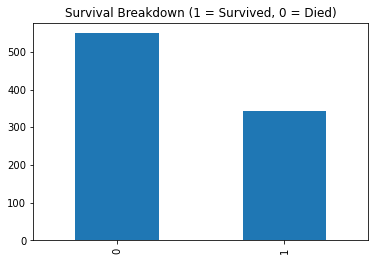

In [85]:
import matplotlib.pyplot as plt 
train_data["Survived"].value_counts().plot(kind='bar')
plt.title("Survival Breakdown (1 = Survived, 0 = Died)")
print(train_data["Survived"].value_counts())

In [86]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

3 passenger classes in this case

male      577
female    314
Name: Sex, dtype: int64


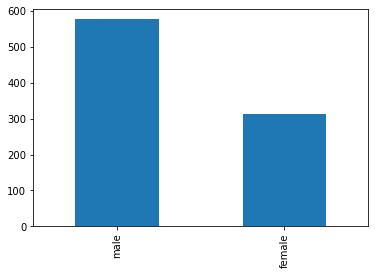

In [87]:
# Men/Women Ratio
train_data["Sex"].value_counts().plot(kind='bar')
print(train_data["Sex"].value_counts())

We note that the ratio of total females on the ship is very close to the actual number that survived... With that intuition, we could assume that most females survived, but we will look into this further. Obviously there are more survivors than total women so under this assumption, some of the survivors were male, possibly young boys.

In [88]:
male = train_data[train_data["Sex"]=="male"]["Survived"].value_counts().sort_index()

In [89]:
female = train_data[train_data["Sex"]=="female"]["Survived"].value_counts().sort_index()

0    468
1    109
Name: Survived, dtype: int64


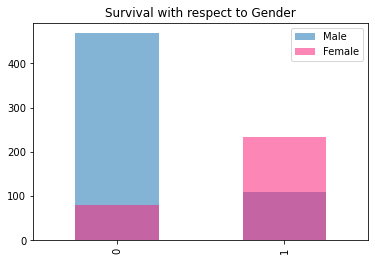

In [90]:
male.plot(kind='bar',label='Male', alpha=0.55)
female.plot(kind='bar', color='#FA2379',label='Female', alpha=0.55)
plt.title("Survival with respect to Gender")
plt.legend(loc='best')
print(male)

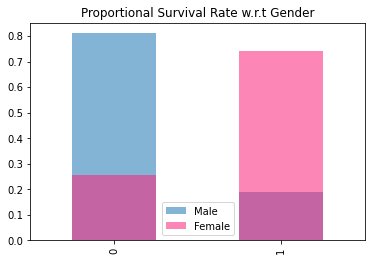

In [91]:
(male/float(male.sum())).plot(kind='bar',label='Male', alpha=0.55)
(female/float(female.sum())).plot(kind='bar', color='#FA2379',label='Female', alpha=0.55)
plt.title("Proportional Survival Rate w.r.t Gender")
plt.legend(loc='best')

<AxesSubplot:>

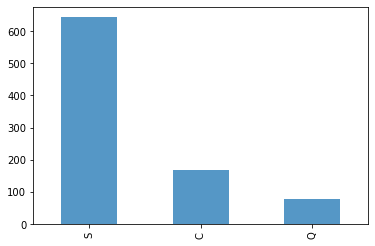

In [92]:
train_data["Embarked"].value_counts().plot(kind='bar', alpha=0.76)

The Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton.

Time to build a preprocessing pipleline:

In [93]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")), # median value for N/A values
        ("scaler", StandardScaler())
    ])

In [94]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(sparse=False))
])

In [95]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

In [96]:
X_train = preprocess_pipeline.fit_transform(train_data[num_attribs + cat_attribs])
X_train

array([[-0.56573646,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.66386103,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.1046374 ,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276197, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

In [97]:
y_train = train_data["Survived"]

In [98]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [99]:
X_test = preprocess_pipeline.transform(test_data[num_attribs + cat_attribs])
y_pred = reg.predict(X_test)

In [100]:
from sklearn.model_selection import cross_val_score

lin_reg_scores = cross_val_score(reg, X_train, y_train, cv=10)
lin_reg_scores.mean()

0.36339755079290914

In [101]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [102]:
X_test = preprocess_pipeline.transform(test_data[num_attribs + cat_attribs])
y_pred = log_reg.predict(X_test)

In [103]:
log_reg_scores = cross_val_score(log_reg, X_train, y_train, cv=10)
log_reg_scores.mean()

0.7991260923845193

In [104]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [105]:
X_test = preprocess_pipeline.transform(test_data[num_attribs + cat_attribs])
y_pred = rfc.predict(X_test)

In [106]:
rfc_scores = cross_val_score(rfc, X_train, y_train, cv=10)
rfc_scores.mean()

0.8070287141073658

In [107]:
from sklearn.svm import SVC

svm = SVC(gamma="auto")
svm.fit(X_train, y_train)

SVC(gamma='auto')

In [108]:
X_test = preprocess_pipeline.transform(test_data[num_attribs + cat_attribs])
y_pred = svm.predict(X_test)

In [109]:
svm_scores = cross_val_score(svm, X_train, y_train, cv=10)
svm_scores.mean()

0.8249313358302123

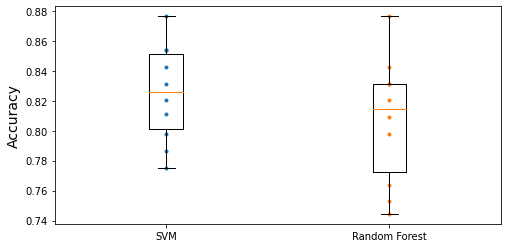

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, rfc_scores, ".")
plt.boxplot([svm_scores, rfc_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

In [111]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
test_data["RelativesOnboard"] = test_data["SibSp"] + test_data["Parch"]

In [112]:
# see what other correlations can be identified 
train_data.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare,RelativesOnboard
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.016639
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,0.065997
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,-0.301914
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,0.890712
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,0.783111
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,0.217138
RelativesOnboard,0.016639,0.065997,-0.301914,0.890712,0.783111,0.217138,1.000000


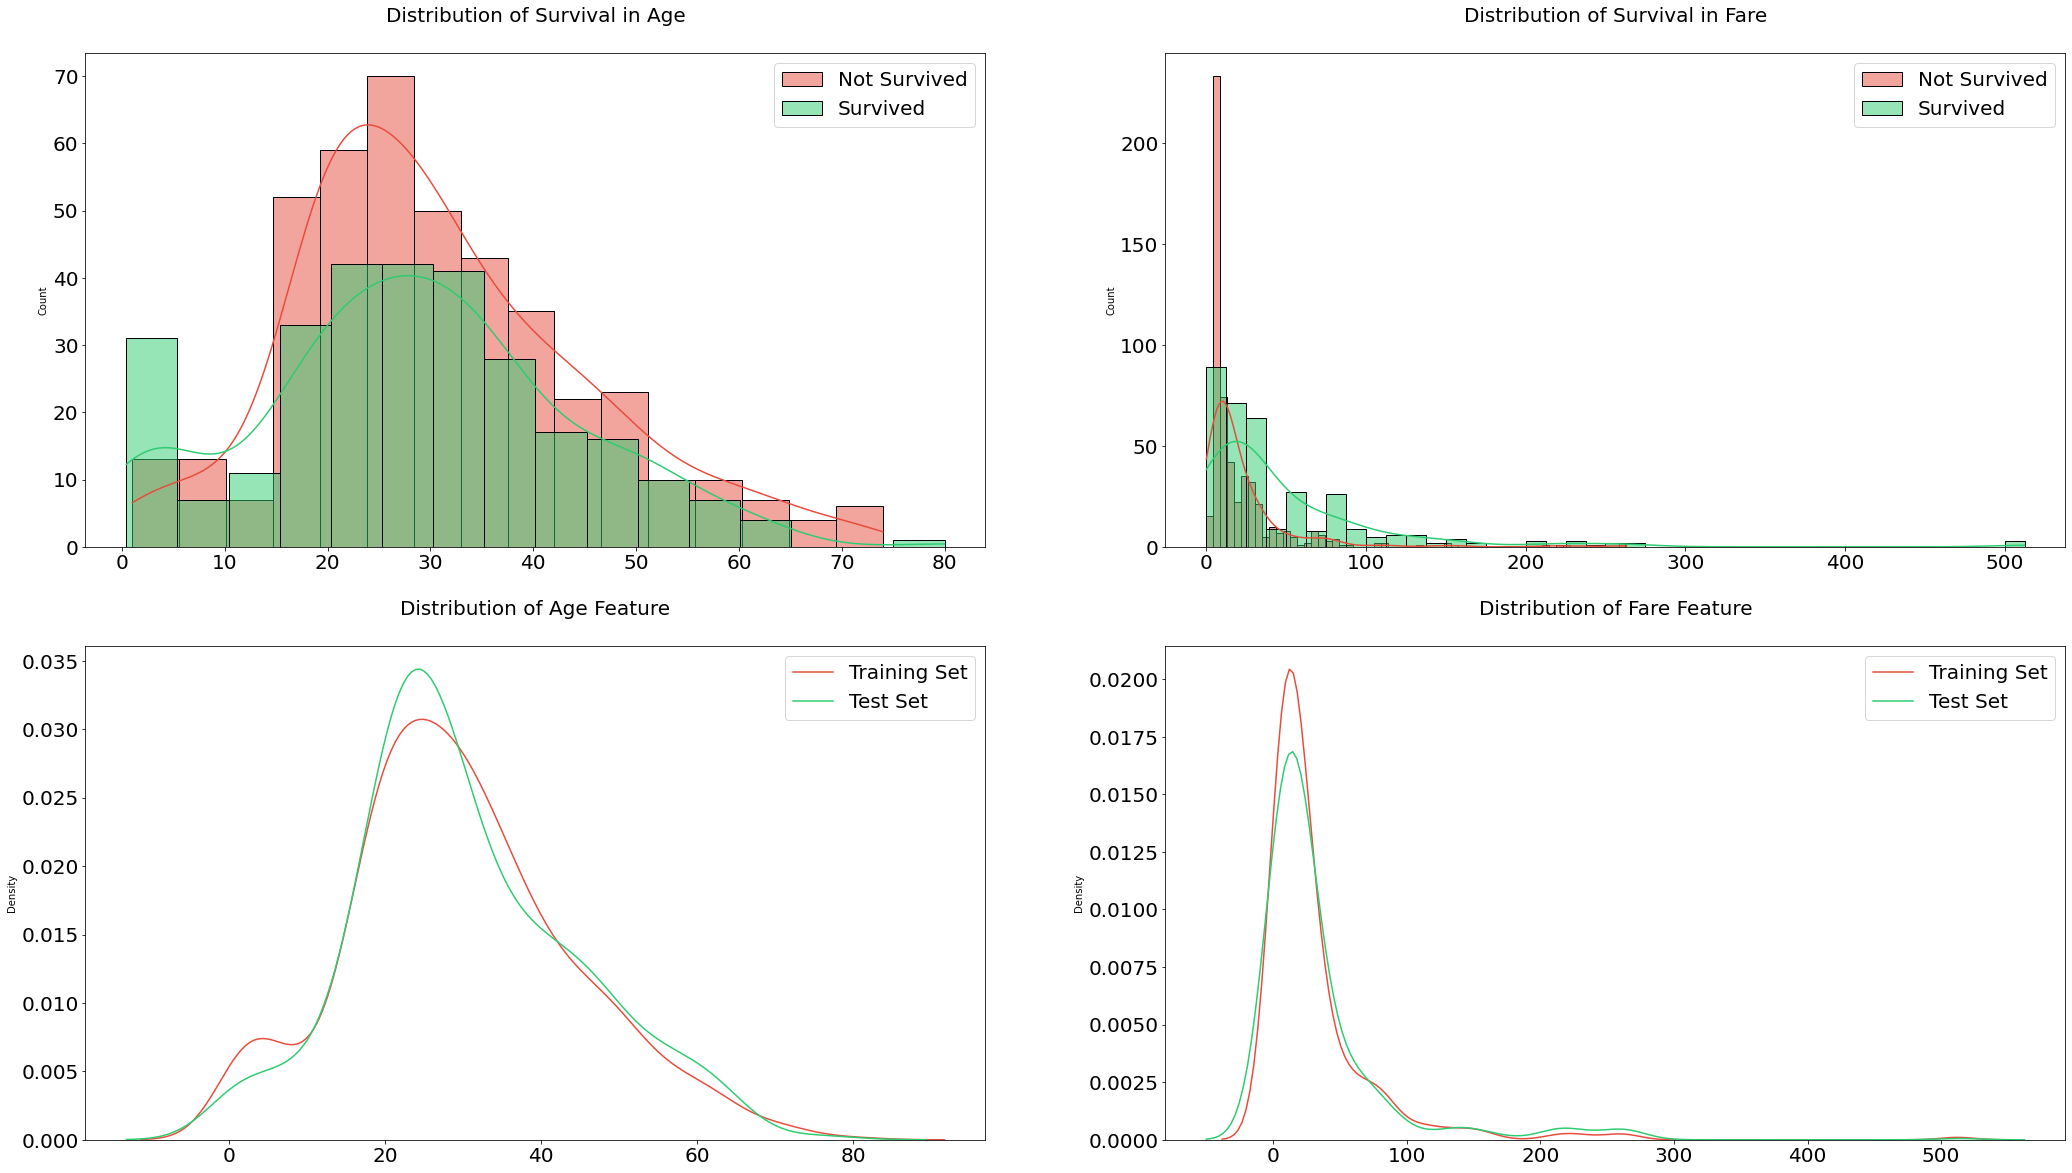

In [113]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
cont_features = ['Age', 'Fare']
surv = train_data['Survived'] == 1

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):    
    # Distribution of survival in feature
    sns.histplot(train_data[~surv][feature], label='Not Survived', kde=True, color='#e74c3c', ax=axs[0][i])
    sns.histplot(train_data[surv][feature], label='Survived', kde=True, color='#2ecc71', ax=axs[0][i])
    
    # Distribution of feature in dataset
    sns.distplot(train_data[feature], label='Training Set', hist=False, color='#e74c3c', ax=axs[1][i])
    sns.distplot(test_data[feature], label='Test Set', hist=False, color='#2ecc71', ax=axs[1][i])
    
    axs[0][i].set_xlabel('')
    axs[1][i].set_xlabel('')
    
    for j in range(2):        
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
    
    axs[0][i].legend(loc='upper right', prop={'size': 20})
    axs[1][i].legend(loc='upper right', prop={'size': 20})
    axs[0][i].set_title('Distribution of Survival in {}'.format(feature), size=20, y=1.05)

axs[1][0].set_title('Distribution of {} Feature'.format('Age'), size=20, y=1.05)
axs[1][1].set_title('Distribution of {} Feature'.format('Fare'), size=20, y=1.05)
        
plt.show()

In [114]:
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
test_data["AgeBucket"] = test_data["Age"] // 15 * 15

In [115]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,RelativesOnboard,AgeBucket
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,15.0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,30.0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,15.0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,30.0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,30.0


In [116]:
num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")), # median value for N/A values
        ("scaler", StandardScaler())
    ])

In [117]:
cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(sparse=False))
])

In [118]:
num_attribs = ["Age", "SibSp", "Parch", "Fare", "RelativesOnboard"]
cat_attribs = ["Pclass", "Sex", "Embarked", "AgeBucket"]

preprocess_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

In [119]:
X_train = preprocess_pipeline.fit_transform(train_data[num_attribs + cat_attribs])
X_train

array([[-0.56573646,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.66386103,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  0.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.1046374 ,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  0.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.20276197, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  0.        ]])

In [120]:
y_train = train_data["Survived"]

In [121]:
svm = SVC(gamma="auto")
svm.fit(X_train, y_train)

SVC(gamma='auto')

In [122]:
X_test = preprocess_pipeline.transform(test_data[num_attribs + cat_attribs])
y_pred = svm.predict(X_test)

In [123]:
svm_scores = cross_val_score(svm, X_train, y_train, cv=10)
svm_scores.mean()

0.8294257178526842

In [124]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [10, 100, 1000, 10000, 100000], 'gamma': [1,0.1,0.01,0.001, 0.0001],'kernel': ['rbf', 'sigmoid', 'sigmoid']}
svm_reg = SVC()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, refit=True, scoring= 'accuracy', verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ......................C=10, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ......................C=10, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ......................C=10, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ......................C=10, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ......................C=10, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ......................C=10, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ......................C=10, gamma=1, k

[CV] END ...................C=100, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..................C=100, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ..................C=100, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ..................C=100, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ..................C=100, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ..................C=100, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ..................C=100, gamma=0.01, kernel=sigmoid; total time=   0.0s
[CV] END ..................C

[CV] END ................C=1000, gamma=0.001, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=1000, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ...................C=1000, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ...................C=1000, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ...................C=1000, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ...................C=1000, gamma=0.0001, kernel=rbf; total time=   0.0s
[CV] END ...............C=1000, gamma=0.0001, kernel=sigmoid; total time=   0.0s
[CV] END ...............C=1000, gamma=0.0001, kernel=sigmoid; total time=   0.0s
[CV] END ...............C=1000, gamma=0.0001, kernel=sigmoid; total time=   0.0s
[CV] END ...............C=1000, gamma=0.0001, kernel=sigmoid; total time=   0.0s
[CV] END ...............C=1000, gamma=0.0001, kernel=sigmoid; total time=   0.0s
[CV] END ...............C=1000, gamma=0.0001, kernel=sigmoid; total time=   0.0s
[CV] END ...............C=10

[CV] END ..................C=100000, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ..................C=100000, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ....................C=100000, gamma=0.1, kernel=rbf; total time=   0.4s
[CV] END ....................C=100000, gamma=0.1, kernel=rbf; total time=   0.7s
[CV] END ....................C=100000, gamma=0.1, kernel=rbf; total time=   0.6s
[CV] END ....................C=100000, gamma=0.1, kernel=rbf; total time=   0.8s
[CV] END ....................C=100000, gamma=0.1, kernel=rbf; total time=   1.4s
[CV] END ................C=100000, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ................C=100000, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ................C=100000, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ................C=100000, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ................C=100000, gamma=0.1, kernel=sigmoid; total time=   0.0s
[CV] END ................C=1

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [10, 100, 1000, 10000, 100000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'sigmoid', 'sigmoid']},
             scoring='accuracy', verbose=2)

In [125]:
grid_search.best_params_

{'C': 10000, 'gamma': 0.001, 'kernel': 'rbf'}

In [126]:
svm = SVC(C = 10000, gamma= 0.001, kernel='rbf')
svm.fit(X_train, y_train)

SVC(C=10000, gamma=0.001)

In [127]:
X_test = preprocess_pipeline.transform(test_data[num_attribs + cat_attribs])
y_pred = svm.predict(X_test)

In [128]:
svm_scores = cross_val_score(svm, X_train, y_train, cv=10)
svm_scores.mean()

0.8350312109862671

In [129]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal 
param_dist = {'C': reciprocal(20, 2000000), 'gamma': expon(scale=1.0),'kernel': ['rbf', 'sigmoid']}
svm_reg = SVC()
randomgrid_search = RandomizedSearchCV(svm_reg, param_dist, cv=10, refit=True, scoring= 'accuracy', verbose=2)
randomgrid_search.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END C=889375.8122007217, gamma=2.661568428035454, kernel=sigmoid; total time=   0.0s
[CV] END C=889375.8122007217, gamma=2.661568428035454, kernel=sigmoid; total time=   0.0s
[CV] END C=889375.8122007217, gamma=2.661568428035454, kernel=sigmoid; total time=   0.0s
[CV] END C=889375.8122007217, gamma=2.661568428035454, kernel=sigmoid; total time=   0.0s
[CV] END C=889375.8122007217, gamma=2.661568428035454, kernel=sigmoid; total time=   0.0s
[CV] END C=889375.8122007217, gamma=2.661568428035454, kernel=sigmoid; total time=   0.0s
[CV] END C=889375.8122007217, gamma=2.661568428035454, kernel=sigmoid; total time=   0.0s
[CV] END C=889375.8122007217, gamma=2.661568428035454, kernel=sigmoid; total time=   0.0s
[CV] END C=889375.8122007217, gamma=2.661568428035454, kernel=sigmoid; total time=   0.0s
[CV] END C=889375.8122007217, gamma=2.661568428035454, kernel=sigmoid; total time=   0.0s
[CV] END C=18238.456606573374, gamma=

[CV] END C=139.1858778538414, gamma=0.08437766603018437, kernel=rbf; total time=   0.0s
[CV] END C=139.1858778538414, gamma=0.08437766603018437, kernel=rbf; total time=   0.0s
[CV] END C=139.1858778538414, gamma=0.08437766603018437, kernel=rbf; total time=   0.0s
[CV] END C=139.1858778538414, gamma=0.08437766603018437, kernel=rbf; total time=   0.0s
[CV] END C=139.1858778538414, gamma=0.08437766603018437, kernel=rbf; total time=   0.0s
[CV] END C=139.1858778538414, gamma=0.08437766603018437, kernel=rbf; total time=   0.0s


RandomizedSearchCV(cv=10, estimator=SVC(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D810B780B8>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D810B78828>,
                                        'kernel': ['rbf', 'sigmoid']},
                   scoring='accuracy', verbose=2)

In [130]:
randomgrid_search.best_params_

{'C': 139.1858778538414, 'gamma': 0.08437766603018437, 'kernel': 'rbf'}

In [131]:
svm = SVC(C = 2630.2729672480114, gamma= 0.43653468226234343, kernel='rbf')
svm.fit(X_train, y_train)

SVC(C=2630.2729672480114, gamma=0.43653468226234343)

In [132]:
X_test = preprocess_pipeline.transform(test_data[num_attribs + cat_attribs])
y_pred = svm.predict(X_test)

In [133]:
svm_scores = cross_val_score(svm, X_train, y_train, cv=10)
svm_scores.mean()

0.7620724094881398

### Best score: 0.8350312109862671

**4. Build a spam classifier (a more challenging exercise):
• Download examples of spam and ham from Apache SpamAssassin’s public
datasets.
• Unzip the datasets and familiarize yourself with the data format.
• Split the datasets into a training set and a test set.
• Write a data preparation pipeline to convert each email into a feature vector.
Your preparation pipeline should transform an email into a (sparse) vector that
indicates the presence or absence of each possible word. For example, if all
emails only ever contain four words, “Hello,” “how,” “are,” “you,” then the email
“Hello you Hello Hello you” would be converted into a vector [1, 0, 0, 1]
(meaning [“Hello” is present, “how” is absent, “are” is absent, “you” is
present]), or [3, 0, 0, 2] if you prefer to count the number of occurrences of
each word.
You may want to add hyperparameters to your preparation pipeline to control
whether or not to strip off email headers, convert each email to lowercase,
remove punctuation, replace all URLs with “URL,” replace all numbers with
“NUMBER,” or even perform stemming (i.e., trim off word endings; there are
Python libraries available to do this).
Finally, try out several classifiers and see if you can build a great spam classi‐
fier, with both high recall and high precision.**

In [134]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", HAM_URL), ("spam.tar.bz2", SPAM_URL)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=SPAM_PATH)
        tar_bz2_file.close()

In [135]:
fetch_spam_data()

In [136]:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [137]:
len(ham_filenames)

2500

In [138]:
len(spam_filenames)

500

In [139]:
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [140]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

In [141]:
print(ham_emails[2].get_content().strip())

Man Threatens Explosion In Moscow 

Thursday August 22, 2002 1:40 PM
MOSCOW (AP) - Security officers on Thursday seized an unidentified man who
said he was armed with explosives and threatened to blow up his truck in
front of Russia's Federal Security Services headquarters in Moscow, NTV
television reported.
The officers seized an automatic rifle the man was carrying, then the man
got out of the truck and was taken into custody, NTV said. No other details
were immediately available.
The man had demanded talks with high government officials, the Interfax and
ITAR-Tass news agencies said. Ekho Moskvy radio reported that he wanted to
talk with Russian President Vladimir Putin.
Police and security forces rushed to the Security Service building, within
blocks of the Kremlin, Red Square and the Bolshoi Ballet, and surrounded the
man, who claimed to have one and a half tons of explosives, the news
agencies said. Negotiations continued for about one and a half hours outside
the building, ITAR-

In [142]:
print(spam_emails[3].get_content().strip())

##################################################
#                                                #
#                 Adult Club                     #
#           Offers FREE Membership               #
#                                                #
##################################################

>>>>>  INSTANT ACCESS TO ALL SITES NOW
>>>>>  Your User Name And Password is.
>>>>>  User Name: zzzz@spamassassin.taint.org
>>>>>  Password: 760382

5 of the Best Adult Sites on the Internet for FREE!
---------------------------------------
NEWS 08/18/02
With just over 2.9 Million Members that signed up for FREE, Last month there were 721,184 New
Members. Are you one of them yet???
---------------------------------------
Our Membership FAQ

Q. Why are you offering free access to 5 adult membership sites for free?
A. I have advertisers that pay me for ad space so you don't have to pay for membership.

Q. Is it true my membership is for life?
A. Absolutely you'll never have to pay a cen

In [143]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [144]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [145]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [146]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

In [147]:
for header, value in spam_emails[0].items():
    print(header,":",value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

In [148]:
spam_emails[0]["Subject"]

'Life Insurance - Why Pay More?'

In [149]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [150]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

In [151]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

In [152]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

In [153]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [154]:
print(email_to_text(sample_html_spam)[:100], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


In [155]:
try:
    import nltk

    stemmer = nltk.PorterStemmer()
    for word in ("Computations", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
        print(word, "=>", stemmer.stem(word))
except ImportError:
    print("Error: stemming requires the NLTK module.")
    stemmer = None

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


In [156]:
!pip install urlextract
try:
    import urlextract # may require an Internet connection to download root domain names
    
    url_extractor = urlextract.URLExtract()
    print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))
except ImportError:
    print("Error: replacing URLs requires the urlextract module.")
    url_extractor = None

  Using cached urlextract-1.4.0-py3-none-any.whl (20 kB)
  Using cached uritools-3.0.2-py3-none-any.whl (12 kB)
['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


In [157]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

In [158]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'url': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 'remsburg': 1, 'letter': 1, 'william': 1, 'short': 1, 'again': 1, 'becom

In [159]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [160]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x11 sparse matrix of type '<class 'numpy.intc'>'
	with 20 stored elements in Compressed Sparse Row format>

In [161]:
X_few_vectors.toarray()

array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [99, 11,  9,  8,  3,  1,  3,  1,  3,  2,  3],
       [67,  0,  1,  2,  3,  4,  1,  2,  0,  1,  0]], dtype=int32)

In [162]:
vocab_transformer.vocabulary_

{'the': 1,
 'of': 2,
 'and': 3,
 'to': 4,
 'url': 5,
 'all': 6,
 'in': 7,
 'christian': 8,
 'on': 9,
 'by': 10}

In [163]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [164]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, verbose=3)
score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] END ................................ score: (test=0.981) total time=   0.0s
[CV] END ................................ score: (test=0.984) total time=   0.0s
[CV] END ................................ score: (test=0.990) total time=   0.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished


0.985

In [165]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 96.88%
Recall: 97.89%
